# Computer Vision and Deep Learning 
## Lab 1 - Kinect Task 2


In [2]:
# # 2D view:
# - Depth is represented by have the nearest objects be Brighter (each pixel being Black, White or a shade of grey)
# - Infrared would be useful when showing people in the dark, 0
# # 3D view
# - Pointcloud is flickering because 
# - It can only detect 1 skeletons
# - The number of joints is 9

# Computer Vision and Deep Learning 
## Lab 1 - Kinect Task 2

The following notebook provides functionality which loads pre-captured frames from the KinectV2 and allows you to explore the 3D space in an open3D viewer.


## Imports <a id="imports"></a>
The following section defines the imports used for the rest of the notebook.

In [3]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


C:\Python310\python.exe: No module named pip


In [21]:
pip install -U pip>=20.3

Note: you may need to restart the kernel to use updated packages.


C:\Python310\python.exe: No module named pip


In [5]:
pip install open3d

Note: you may need to restart the kernel to use updated packages.


C:\Python310\python.exe: No module named pip


In [ ]:
conda - conda install -c open3d-admin open3d

ValueError: The python kernel does not appear to be a conda environment.  Please use ``%pip install`` instead.

In [6]:
# For ndarray handling:
import numpy as np

# For pointcloud manipulation
import open3d as oed

# For plotting:
import matplotlib.pyplot as plt

# For RealSense device configuration
import json

ImportError: DLL load failed while importing open3d: The specified module could not be found.

# Diving Deeper with Pre-captured data
## Load in pre-captured data to work with
The frames on disk are color, depth and infrared maps captured by the KinectV2. 

For the color maps we require a `Height` $\times$ `Width` $\times$ `Channel` ndarray (due to the color information), depth and infrared maps both require a `Height` $\times$ `Width` ndarray (as these are only 1D).

The native KinectV2 color map resolution is `Height`: 1080, `Width`: 1920, and `Channel`: 3 (BGR - Blue, Green, Red order). 

The depth and infrared streams are `Height`: 424, `Width`: 512.

In [2]:
# Load frames
image_frame = np.load("./Image.npy")
depth_frame = np.load("./Depth.npy")
infrared_frame = np.load("./Infrared.npy")

# Frame dimensions
image_h, image_w, image_c = image_frame.shape # RGB frame shapes
depth_h, depth_w = depth_frame.shape # Depth frame shapes
infrared_h, infrared_w = infrared_frame.shape # Infrared frame shapes

Note that the resolution of the two cameras are not the same. The depth sensor and appearance sensor images are not the same size, and also are not taken from the same viewpoint.

There is an aligned version available in "KinectV2_ImageAligned_frame00.npy", we'll use this later. 

In [3]:
print(f'image_frame shape: {image_frame.shape}')
print(f'depth_frame shape: {depth_frame.shape}')
print(f'infrared_frame shape: {infrared_frame.shape}')

image_frame shape: (1080, 1920, 3)
depth_frame shape: (424, 512)
infrared_frame shape: (424, 512)


## Lets take a look at the captured frame

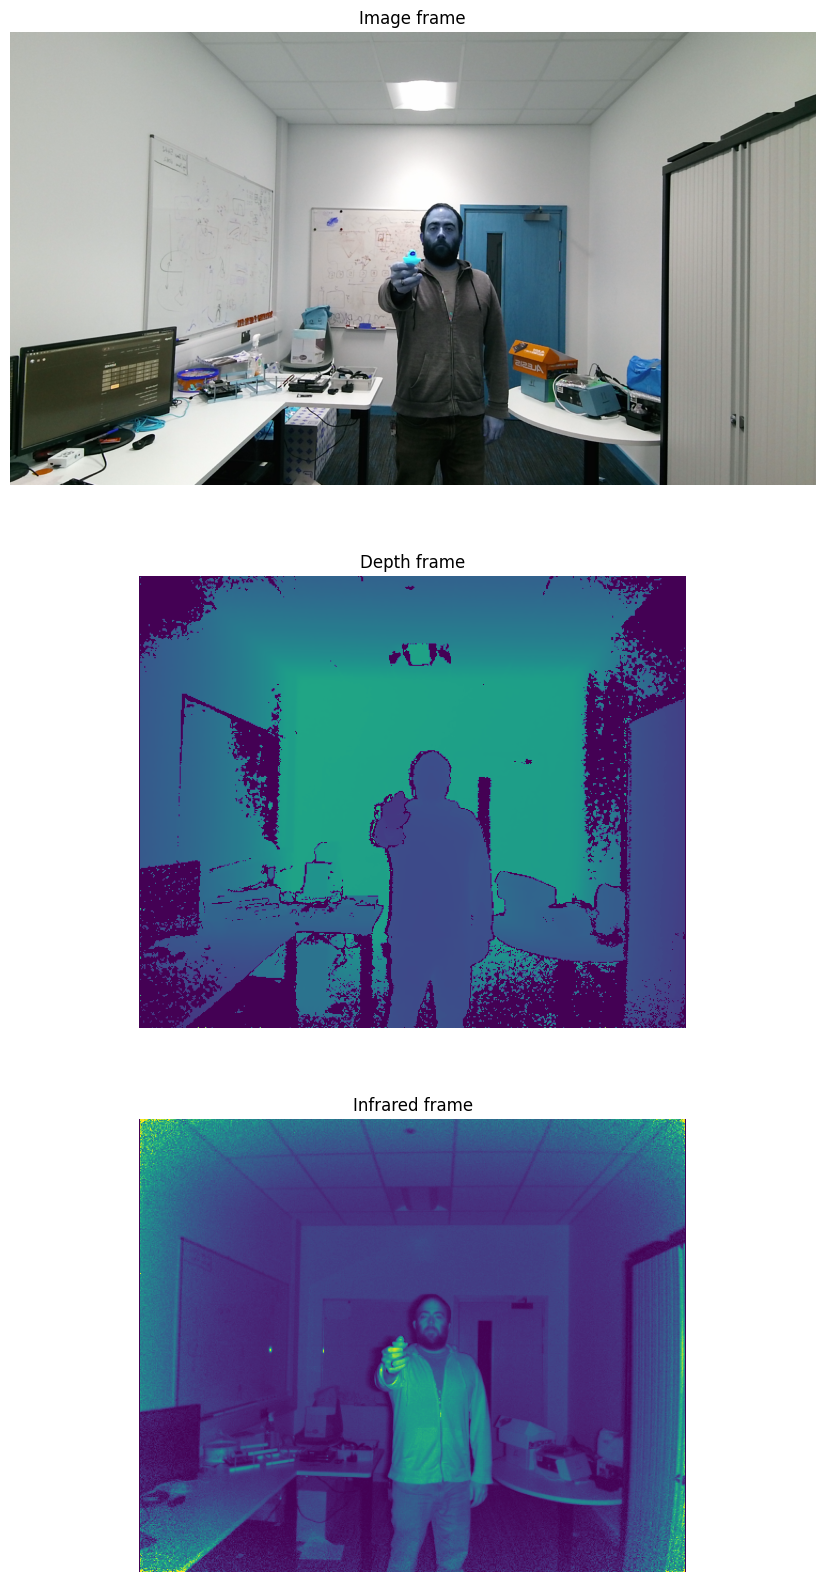

In [6]:
plt.figure(figsize=[20,20])

ax1 = plt.subplot(311)
ax1.imshow(image_frame)
ax1.set_title('Image frame')
ax1.axis('off')

ax2 = plt.subplot(312)
ax2.imshow(depth_frame)
ax2.set_title('Depth frame')
ax2.axis('off')

ax3 = plt.subplot(313)
ax3.imshow(infrared_frame)
ax3.set_title('Infrared frame')
ax3.axis('off')
plt.show()

Note above that the Image frame coloration looks a bit strange. This is because the KinectV2 returns color ordering in BGRA order, rather than the conventional RGB order that matplotlib is expecting. 

To correct this, we can reorder the channels back to RGB:

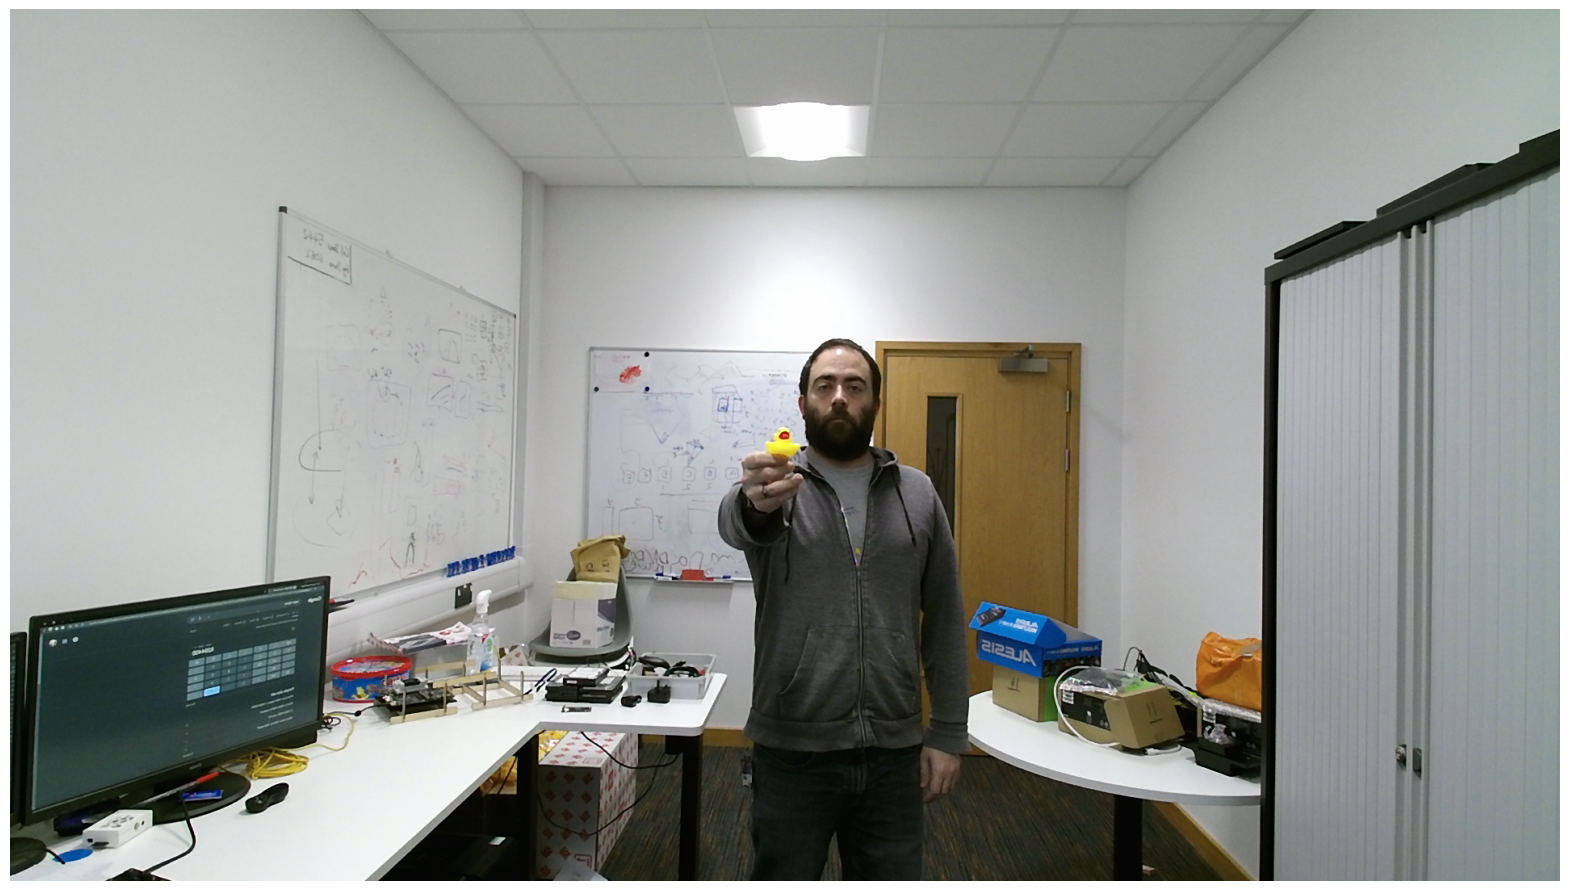

In [7]:
image_frame = image_frame[:,:,[2,1,0]]

plt.figure(figsize=[20,20])
plt.imshow(image_frame)
plt.axis('off')
plt.show()

## Plot 3D pointcloud
Here we will use the Open3D (http://www.open3d.org/) framework to plot the pointclouds in 3D space. 

We will use a pre-aligned color image to colour our pointcloud.

In [8]:
# Create a spatial subsampling of our maps to reduce the number of points plotted
ws, hs = np.meshgrid(np.arange(0, depth_w), 
                     np.arange(0, depth_h))

# Create our XYZ cloud. X and Y are based on the meshgrid of the depth map, 
# with Z being the depth into the scene
subsample = 1
xyz = np.stack([ws[::subsample,::subsample].flatten(), 
                hs[::subsample,::subsample].flatten(), 
                depth_frame[::subsample,::subsample].flatten()], axis=-1)

# Normalize the scene, not explicitly needed, but can look odd if not done
xyz_min = xyz.min(axis=0)
xyz_max = xyz.max(axis=0)
xyz = (xyz - xyz_min) / (xyz_max - xyz_min) * np.asarray([1, 1, 2])

# Create the Open3D PointCloud object
pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(xyz))

# Provide colors for each of the points in the cloud based on the aligned image
align_frame = np.load('AlignedImage.npy')
align_frame = np.reshape(align_frame[::subsample,::subsample],(-1, 3))
align_frame = align_frame / 255.0
pcd.colors = o3d.utility.Vector3dVector(align_frame)

# Visualize the PointCloud
o3d.visualization.draw_geometries([pcd])

# You can press "H" when in the visualizer to see a list of hotkey options

NameError: name 'o3d' is not defined

# Using the RealSense sensors

## List the RealSense devices available to Open3D which are currently plugged into the machine
This will also give some insight into available configuration options which can be parsed via the JSON config file.

In [ ]:
o3d.t.io.RealSenseSensor.list_devices()

## Create a RealSense Sensor Object

In [ ]:
rs = o3d.t.io.RealSenseSensor()

### If using a config file then load it in here and initialise the sensor with these settings.

In [ ]:
use_config = True
if use_config:
    with open('config.json') as cf:
        config = json.load(cf)
        rs_cfg = o3d.t.io.RealSenseSensorConfig(config)
    print(config)
    rs.init_sensor(rs_cfg)

## Capture a sample from the sensor

In [ ]:
rs.start_capture(True)
for fid in range(150):
    im_rgbd = rs.capture_frame(True, True)
rs.stop_capture()

In [ ]:
rgbdimage = o3d.geometry.RGBDImage.create_from_color_and_depth(im_rgbd.color.to_legacy(), 
                                                                   im_rgbd.depth.to_legacy(), 
                                                                   convert_rgb_to_intensity=0, 
                                                                   depth_trunc=250.0)

## Convert the RGBD image into a PointCloud

In [ ]:
realsense_intrinsics =  o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)
pc = o3d.geometry.PointCloud.create_from_rgbd_image(rgbdimage, realsense_intrinsics)
o3d.visualization.draw_geometries([pc])